In [ ]:
Data Loading ,Cleaning ,EDA & Visualization:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Loading the Dataset
import pandas as pd
df = pd.read_csv('C:/Users/Kishore/Desktop/GUVI/fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
As we can see there are inconsistency in column names so we will cahange the column names for consistency.

In [11]:
df = df.rename(columns={'nameOrig':'nameorig','oldbalanceOrg':'oldbalanceorig','newbalanceOrig':'newbalanceorig','nameDest':'namedest'
    ,'oldbalanceDest':'oldbalancedest','newbalanceDest':'newbalancedest'})
df.columns

Index(['step', 'type', 'amount', 'nameorig', 'oldbalanceorig',
       'newbalanceorig', 'namedest', 'oldbalancedest', 'newbalancedest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [ ]:
1.) Data cleaning including missing values, outliers and multi-collinearity

In [13]:
df.isnull().sum()

step              0
type              0
amount            0
nameorig          0
oldbalanceorig    0
newbalanceorig    0
namedest          0
oldbalancedest    0
newbalancedest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
As we can see there are no missing values in Dataset but that does not mean we have no null values becaue there can be 0 values in some variables.
There is no point in checking outliers because it is finacial data where bank balance can be any real number value so there is really no parameter where we can scale it.

In [ ]:
Multi-collinearity -

In [14]:
df1 = df.copy(deep = 'true')
df1['type']=df1['type'].map({'PAYMENT':1 ,'TRANSFER':2, 'CASH_OUT':3, 'DEBIT':4, 'CASH_IN':5})
df1 = df1.drop(columns = ['nameorig','namedest','isFraud','isFlaggedFraud'])
df1.head()

,step,type,amount,oldbalanceorig,newbalanceorig,oldbalancedest,newbalancedest
0,1,1,9839.64,170136.0,160296.36,0.0,0.0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0
2,1,2,181.00,181.0,0.00,0.0,0.0
3,1,3,181.00,181.0,0.00,21182.0,0.0
4,1,1,11668.14,41554.0,29885.86,0.0,0.0


In [15]:
#calculating VIf to check the MUlti-collinearity between variables -

vif_data = pd.DataFrame()                         
vif_data["feature"] = df1.columns
vif_data["VIF"] = [variance_inflation_factor(df1.values, i)
                          for i in range(len(df1.columns))]
print(vif_data)

          feature         VIF
0            step    2.466060
1            type    3.251976
2          amount    4.129854
3  oldbalanceorig  501.282300
4  newbalanceorig  508.906801
5  oldbalancedest   73.377939
6  newbalancedest   84.656570


In [ ]:
As we can see, oldbalance and newbalance have very high values of VIF, indicating that these two variables are highly correlated. This is expected as the transaction happens does changes their values. Hence, considering these two features together leads to a model with high multicollinearity.

In [ ]:
1. which type of transactions are fraud using isFraud -
There are 2 flags From those,isFraud is the indicator which indicates the actual fraud transactions whereas isFlaggedFraud is what the system prevents the transaction due to some thresholds being triggered.

In [16]:
print('Type of transaction which are fraud:{}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

fraud_transfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraud_cashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
 

print('number of transfer are fraud :{}'.format(len(fraud_transfer)))
print('number of cashout are fraud :{}'.format(len(fraud_cashout)))

Type of transaction which are fraud:['TRANSFER', 'CASH_OUT']
number of transfer are fraud :4097
number of cashout are fraud :4116


In [ ]:
2. Analysis on isFlaggedFraud variable -
isFlaggedFraud = The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [17]:
amount_flagfraud0 = list(df.loc[(df.isFlaggedFraud == 0) ].amount.values)
amount_flagfraud1 = list(df.loc[(df.isFlaggedFraud == 1) ].amount.values)
print('minimum amount transfer where isFlaggedFraud is 1 = {}'.format(min(amount_flagfraud1)))
print('maximum amount transfer where isFlaggedFraud is 0 = {}'.format(max(amount_flagfraud0)))
print('Number of isFlaggedFraud == 1 : {}'.format(len(list(df.loc[df.isFlaggedFraud ==1 ].isFlaggedFraud.values))))


minimum amount transfer where isFlaggedFraud is 1 = 353874.22
maximum amount transfer where isFlaggedFraud is 0 = 92445516.64
Number of isFlaggedFraud == 1 : 16


In [ ]:
isFlaggedFraud variable is set to 1 when transfer is more than 200,000 in single transaction but we can see that from above analysis. This variable is useless because maximum amount transfer in single transcation is 92445516.64 , There are only 16 values where isFlaggedFraud is set so we will drop this feature.

In [ ]:
3. Oldblanceorig and newbalanceorig variable -
From below analysis we can see that as multiple newbalancedset and oldbalance dest have zero values because the transaction is put on hold & there are no information available for merchants.

In [18]:
print('numebr of recipant who have newbalancedest and oldbalancedest is zero :{}'
      .format(len(df.loc[(df.newbalancedest == 0) & (df.oldbalancedest == 0) ].namedest.values)))

numebr of recipant who have newbalancedest and oldbalancedest is zero :2317282


In [ ]:
From below analysis we can see that there is transaction amount but our odlbalanceorig & newbalanceorig are zero,That doesn't make sense because if amount is there that means transaction is happened . so there are must be error in these variable or missing values

In [23]:
zero_balance = list(df.loc[(df.oldbalanceorig == 0) & (df.newbalanceorig == 0) & (df.amount != 0)].type.values)

print('Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :{}'.format(len(zero_balance)))


Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :2088969


In [ ]:
Lets see how many merchants account in originator accounts and does merchants account have fraud transaction ?
oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

In [24]:
print('number of merchants in originator transaction: {}' .format(df.nameorig.str.contains('M').any()))
print('number of merchant acoount in destination where type is Transfer : {}' .format(df.loc[df.type =='TRANSFER'].namedest.str.contains('M').any()))
print('number of merchant acoount in destination where type is cashout : {}' .format(df.loc[df.type =='CASH_OUT'].namedest.str.contains('M').any()))


number of merchants in originator transaction: False
number of merchant acoount in destination where type is Transfer : False
number of merchant acoount in destination where type is cashout : False


In [ ]:
There are no Merchant account through Fraud transaction is happen so missing information does not affect while building model

In [ ]:
Data cleaning -
3. How did you select variables to be included in the model?
From above analysis we know that fraud is only occured in 'TRANSFER' and 'CASH_OUT'. sow we choose only those type of payment and we will remove Variables -[ nameorig , namedest , isFlaggedFraud ]

In [25]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
y = x.isFraud
x = x.drop(['isFraud','isFlaggedFraud','nameorig','namedest'],axis = 1)
x['type']= x['type'].map({'TRANSFER':1,'CASH_OUT':2})

In [ ]:
Replacing missing values -
There are transactions where newbalanceorig and oldbalanceorig is zero while amount is non zero so we replace them with np.nan.
There are newblancedest and oldbalancedest values are equal to zero but we can notimpute them because they shows the fraud transaction occured when amount is non zero instead of imputing them by 0 = -1

In [ ]:
x.loc[(x.oldbalancedest == 0) & (x.newbalancedest == 0) & (x.amount != 0) ,['oldbalancedest','newbalancedest'] ] = -1 
x.loc[(x.oldbalanceorig == 0) & (x.newbalanceorig == 0) & (x.amount != 0) ,['oldbalanceorig','newbalanceorig'] ] = 0 

#imputing missing values

In [ ]:
Feature engineering -
From above analysis we can create two features of error at origin and destination account, where non zero amount is transfer but oldbalance and new balance have zero value

In [26]:
x['errorbalanceorig'] = x.newbalanceorig + x.amount - x.oldbalanceorig   # eg origin- oldbal = 10 ,newbal = 8 ,amount = 2 so, error =  8+2-10 = 0 
x['errorbalancedest'] = x.oldbalancedest + x.amount - x.newbalancedest   #eg - at dest its opposite , old bal = 8 ,new bal = 10 , amount = 2 :error = 8+2-10 = 0


In [ ]:
Data visualization -
Best way to see that our data can be calssified is to visualize the data .

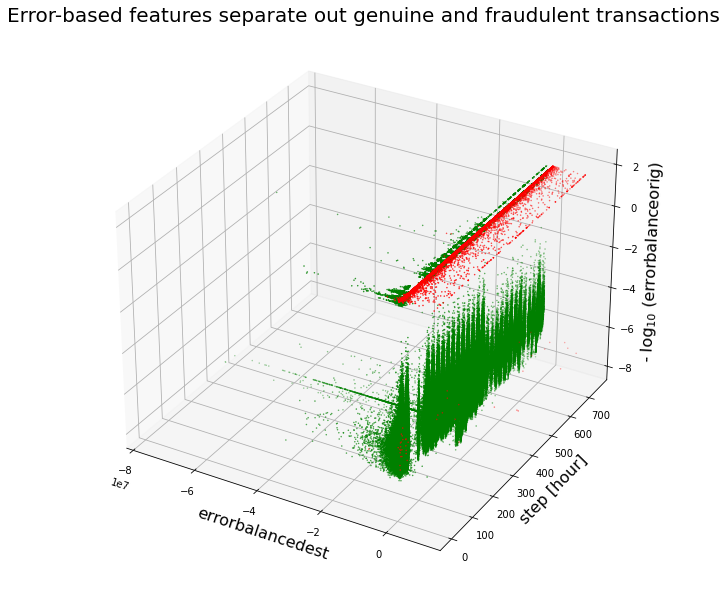

In [27]:
x1 = 'errorbalancedest'                                       
y1 = 'step'
z1= 'errorbalanceorig'
zOffset = 0.02
limit = len(x)

sns.reset_orig() 

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x.loc[y == 0, x1][:limit], x.loc[y == 0, y1][:limit], \
  -np.log10(x.loc[y == 0, z1][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(x.loc[y == 1, x1][:limit], x.loc[y == 1, y1][:limit], \
  -np.log10(x.loc[y == 1, z1][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x1, size = 16); 
ax.set_ylabel(y1 + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')



In [ ]:
We can seprate data using our new features as we can see in our above visualization.

In [ ]:
Machine learning for predicting fraudulent transactions -

In [ ]:
checking if the data is imbalance or skew -

In [29]:
xfraud = x.loc[y==1]
xnotfraud = x.loc[y == 0]

print(len(xfraud))
print(len(xnotfraud))

8213
2762196


In [ ]:
Data split in (80:20) ratio between train and tesy

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=27)

In [ ]:
4.) Demonstrate the performance of the model by using best set of tools.
Selection of metric: Since the data is highly skewed, I use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC).AUPRC on a dataset with 99% negative 1% positive examples, and it will “focus” on how the model handles the 1% positive examples. If the model handles the positive examples well, AUPRC will be high. If the model does poorly on the positive examples, AUPRC will be low.

In [ ]:
2. Describe your fraud detection model in elaboration.
Selection of ML algorithm: A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the dat

In [ ]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())                  #xgb uses the scale_pos_weight to account for highly skewed datset
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights,
                n_jobs = 4)
probabilities = clf.fit(X_train,y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))

In [ ]:
AUPRC = 0.9906371272483061

In [ ]:
SO AUPRC score is 0.99 means our model performing well on positive (fraudlant transaction) class.
CONCLUSION -

7.)What kind of prevention should be adopted while company update its infrastructure?

Company can prevent fraudalnt transaction by focusing more on payment method type - 'Transfer' & 'Cash_out'
Look Out for Patterns in Fraud and Theft
8.)Assuming these actions have been implemented, how would you determine if they work?

we can retrain & maintain model after certain intervals so our model perform best under various fraudlant transaction.